In [1]:
from typing import Annotated, Optional, List, Dict, Any
from langchain_core.messages import ToolMessage, AIMessage, SystemMessage, HumanMessage
from langchain_core.tools import InjectedToolCallId, tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable 
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.types import Interrupt,Command
from pathlib import Path
from dotenv import load_dotenv
import yaml
import re
import textwrap
import json

load_dotenv()

True

In [2]:

# ---------------------------------------------------------------------
# 1 · InputState – what arrives on the very first invoke()
# ---------------------------------------------------------------------
class InputState(BaseModel):
    messages: Annotated[list, add_messages]

# ---------------------------------------------------------------------
# 2 · IntermediateState – everything nodes may read/write
# ---------------------------------------------------------------------
class IntermediateState(BaseModel):
    # flags & classification
    on_topic: Optional[bool] = None

    # employee attributes
    on_project: Optional[int] = None
    tech_stack: Optional[List[str]] = None
    exp: Optional[int] = None
    degree_level: Optional[str] = None

    # HITL bookkeeping
    missing_fields: List[str] = Field(default_factory=list)
    all_fields_present: bool = False
    hitl_pending: Optional[str] = None 

    # SQL generation inputs
    db_name: Optional[str] = "employees"
    table: Optional[str] = "employees"
    fields: List[str] = Field(default_factory=list)
    limit: Optional[int] = None

    # SQL outputs
    sql_query: Optional[str] = None
    query_params: List[Any] = Field(default_factory=list)
    query_results: List[Dict[str, Any]] = Field(default_factory=list)

# ---------------------------------------------------------------------
# 3 · OutputState – what you want back from graph.invoke()
# ---------------------------------------------------------------------
class OutputState(BaseModel):
    results: List[Dict[str, Any]] = Field(default_factory=list)

# ---------------------------------------------------------------------
# 4 · OverallState – single internal schema seen by every node
# ---------------------------------------------------------------------
class OverallState(InputState, IntermediateState, OutputState):
    """Merged state; nodes accept one `state: OverallState` parameter."""
    pass


In [3]:
SYSTEM_PROMPT = """
You are a highly skilled Resource Allocation Agent for a tech company. Your task is to find and suggest the most suitable employees for internal project needs.
You analyze employee attributes such as *exp* (in years), *on_project* status (0 = available, 1 = occupied), *tech_stack*, and *degree_level* (Bachelor, Master, PhD).
Respond clearly, ask follow‑up questions when needed, and always aim to provide actionable results based on user input.
⚠️ Use only the exact database column names: exp, on_project, tech_stack, degree_level.
Do NOT use synonyms like "experience" instead of "exp", or "skills" instead of "tech_stack".
If the question is unrelated to employee resource allocation, reply: "Sorry, I can only help with employee resource allocation questions."
""".strip()


def _latest_user(state) -> Optional[str]:
    # Helper to fetch the most recent user input message
    for msg in reversed(state.messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    return None


llm = ChatGroq(model="llama-3.3-70b-versatile")  # LLM model used for all chains



EMPLOYEE_FIELDS = ["exp", "tech_stack", "on_project", "degree_level"]         # already validated helper

field_extraction_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an intelligent assistant that extracts structured field-value "
        "pairs from a user's natural language query. "
        f"The employee table contains the following fields: {', '.join(EMPLOYEE_FIELDS)}. "
        "If the user provides any of these explicitly or implicitly, extract them into a JSON object. "
        "For example, if the user says 'available', map that to `on_project=0`. "
        "Only include keys that are clearly present in the query. For `tech_stack`, return a list."
    ),
    ("human", "{query}")
])

extractor_chain = field_extraction_prompt | llm | (lambda x: x.content.strip())


def _clean_llm_output(raw: str) -> str:
    """Remove ```json fences and return the first {...} block."""
    cleaned = textwrap.dedent(raw).strip("` \n")
    match = re.search(r"\{[\s\S]*?\}", cleaned)
    return match.group(0) if match else "{}"


def field_extractor_node(state: OverallState) -> Dict[str, Any]:
    """
    Uses an LLM to extract employee attributes (e.g., exp, tech_stack) from the user's input.
    Also identifies which fields are still missing.
    """
    user_msg = _latest_user(state)
    if not user_msg:
        return {}

    try:
        raw_llm = extractor_chain.invoke({"query": user_msg})
        print("[field_extractor] LLM raw:", raw_llm)
        json_text = _clean_llm_output(raw_llm)
        extracted = json.loads(json_text)
    except Exception as err:
        print(f"[field_extractor] ⚠️ Cannot parse LLM output: {err}")
        extracted = {}

    # Keep only valid employee fields
    updates: Dict[str, Any] = {k: v for k, v in extracted.items() if k in EMPLOYEE_FIELDS}

    # Determine what still needs to be collected from the user
    missing = [f for f in EMPLOYEE_FIELDS if f not in updates]
    updates.update(
        missing_fields=missing,
        all_fields_present=len(missing) == 0,
    )
    return updates


def hitl_node(state: OverallState) -> Dict[str, Any]:
    """
    Human-in-the-loop node: asks the user for any missing fields (like exp or degree_level).
    Adds the response to the state.
    """
    if not state.missing_fields:
        return {}

    field = state.missing_fields[0]
    question = f"Please provide a value for **{field}**:"
    answer = interrupt(question)

    # Normalize types based on field type
    if field in {"on_project", "exp"}:
        try:
            answer = int(answer)
        except Exception:
            pass
    elif field == "tech_stack":
        answer = [tok.strip() for tok in str(answer).split(",") if tok.strip()]

    remaining = state.missing_fields[1:]

    # Return only the updates (LangGraph merges this into full state)
    return {
        field: answer,
        "missing_fields": remaining,
        "all_fields_present": len(remaining) == 0,
        "messages": [
            AIMessage(content=question),
            HumanMessage(content=str(answer)),
        ],
    }


In [4]:
@tool("generate_sql_query_and_fetch_db_results")
def generate_and_run_employee_query(
    *,
    db_name: str,
    exp: int = None,
    on_project: int = None,
    tech_stack: list = None,
    degree_level: str = None,
    limit: int = 10
) -> str:
    """
    Generates and executes a SQL query on the `employees` table to find suitable employees for internal project allocation.

    Use this tool when the user is asking to find employees based on filters like:
    - Minimum years of experience (`exp`)
    - Whether the employee is currently available or occupied (`on_project`)
    - Required technical skills (`tech_stack`)
    - Educational qualification (`degree_level`)

    This tool returns a list of matching employees directly from the database.
    """
    from psycopg2.extensions import adapt
    import psycopg2
    import json
    from database.config_db import discover_databases
    from langchain.prompts import ChatPromptTemplate
    from langchain_groq import ChatGroq

    TOOL_PROMPT = """
You are an expert PostgreSQL query generator. Based on the inputs below, return a parameterized SELECT query using %s placeholders.
Use table_name as *employees*
- exp → use exp >= %s
- on_project → on_project = %s
- tech_stack → tech_stack @> %s
- degree_level → degree_level = %s
Always include a LIMIT %s clause.
Only include filters for non-null fields.

Inputs:
- exp: {exp}
- on_project: {on_project}
- tech_stack: {tech_stack}
- degree_level: {degree_level}
- limit: {limit}

Respond ONLY with a JSON object: {{"query": "...", "params": [...]}} — no markdown, no explanations.
"""

    prompt = ChatPromptTemplate.from_template(TOOL_PROMPT)
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.0)
    chain = prompt | llm

    response = chain.invoke({
    "exp": exp,
    "on_project": on_project,
    "tech_stack": tech_stack,
    "degree_level": degree_level,
    "limit": limit
})

    response_text = response.content.strip().strip("`")
    if response_text.startswith("json"):
        response_text = response_text[len("json"):].strip()

    print("[🧠 LLM Raw Response]", repr(response_text))

    try:
        parsed = json.loads(response_text)
    except json.JSONDecodeError as e:
        raise ValueError(f"❌ Failed to parse LLM response: {e}\nRaw: {response_text}")

    query = parsed["query"]
    params = parsed["params"]
    try:
        db = discover_databases()["employees"]
        conn = psycopg2.connect(
            host=db["host"], port=db["port"], dbname=db["dbname"],
            user=db["owner"], password=db["password"]
        )

        # Ensure list-type (tech_stack) params are kept as native Python lists
        clean_params = []
        for p in params:
            if isinstance(p, str) and p.startswith("{") and p.endswith("}"):
                p = p.strip("{}").split(",")
                p = [x.strip(" \"'") for x in p]
            clean_params.append(p)

        print("[Running Query]")
        print("SQL Query:", query)
        print("Params:", clean_params)

        with conn, conn.cursor() as cur:
            cur.execute(query, clean_params)
            cols = [desc.name for desc in cur.description]
            rows = [dict(zip(cols, row)) for row in cur.fetchall()]

    except Exception as err:
        print(f"[resource_allocator] ⚠ {err} — using fallback")
        rows = [
            {"id": 999, "first_name": "Stub", "last_name": "User", "on_project": 0,
             "exp": 42, "tech_stack": ["python", "sql"], "degree_level": "PhD"}
        ]

    return json.dumps({"results": rows})


In [5]:
def tool_node(state: OverallState) -> Dict[str, Any]:
    print("[tool_node] Calling resource_allocator tool via LLM")
    state.messages.append(HumanMessage(content=_latest_user(state)))

    response = llm.bind_tools([generate_and_run_employee_query]).invoke(state.messages)
    if not response.tool_calls:
        raise ValueError("[tool_node] ❌ No tool call found")

    tool_call = response.tool_calls[0]
    tool_output = generate_and_run_employee_query.invoke({
        "db_name": state.db_name,
        "exp": state.exp,
        "on_project": state.on_project,
        "tech_stack": state.tech_stack,
        "degree_level": state.degree_level,
        "limit": state.limit or 10
    }, tool_id=tool_call["id"])

    state.messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))
    parsed = json.loads(tool_output)
    rows = parsed["results"]

    # Let LLM summarize the results directly
    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_PROMPT),
        ("human", f"Given the following result rows, summarize suitable employees:\n{rows}")
    ])
    print("Inside tool_node",SYSTEM_PROMPT )
    summary_chain = summary_prompt | llm
    summary = summary_chain.invoke({}).content.strip()

    return {"messages": [AIMessage(content=summary)], "results": rows}

In [6]:
def route_after_extractor(state: OverallState) -> str:
    """
    Router called after `field_extractor_node`.

    - If all fields are present → proceed to the `tool_node`
    - Else → ask user missing fields via the `hitl` node
    """
    return "tool_node" if state.all_fields_present else "hitl"

def route_after_hitl(state: OverallState) -> str:
    """
    Router called after resuming from HITL interaction.

    - If all fields are now present → proceed to the `tool_node`
    - Else → stay in the HITL loop
    """
    return "tool_node" if state.all_fields_present else "hitl"



In [9]:
import os 
load_dotenv()

llm = ChatGroq(model="llama-3.3-70b-versatile",api_key=os.getenv('GROQ_API_KEY'))
llm = llm.bind_tools([generate_and_run_employee_query])

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ---------------------------------------------------------------------
# 1 · Initialise the builder with overall / I‑O schemas
# ---------------------------------------------------------------------
builder = StateGraph(
    OverallState,           # internal state
    input=InputState,
    output=OverallState     # ← change here
)


# ---------------------------------------------------------------------
# 2 · Register all nodes (single‑arg versions)
# ---------------------------------------------------------------------
builder.add_node("field_extractor",  field_extractor_node)
builder.add_node("hitl",             hitl_node)
builder.add_node("tool_node",      tool_node)
builder.set_entry_point("field_extractor")

# And update routing accordingly
builder.add_conditional_edges(
    "field_extractor",
    route_after_extractor,
    path_map=["tool_node", "hitl"]   # ← updated target
)

builder.add_conditional_edges(
    "hitl",
    route_after_hitl,
    path_map=["tool_node", "hitl"]   # ← updated target
)

builder.add_edge("tool_node", END)
# ---------------------------------------------------------------------
# 4 · Compile with an in‑memory checkpointer
# ---------------------------------------------------------------------
graph = builder.compile(checkpointer=MemorySaver())        # :contentReference[oaicite:3]{index=3}


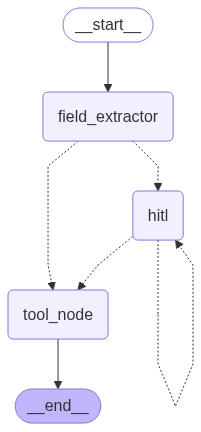

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
# ──────────────────────────────────────────────────────────────────────────────
# Driver / test loop – paste this into a fresh cell
# ──────────────────────────────────────────────────────────────────────────────
import builtins                                    # gives us builtins.input
from langgraph.types import Command                # already used for resume
from langchain_core.messages import HumanMessage   # convenience
# Hi I need an AI engineer -> store the list of parameters for AI Engineer and 
# ---- kick off the first turn -------------------------------------------------
state = {
    "messages": [
        HumanMessage(content="Find an employee who is good in Python, FastAPI, AWS with 4 year of exp")
    ]
}
#Find an employee with 5 yrs exp and good hold in ML
#Find an employee who is good in Python, FastAPI, AWS with 4 year of exp
result = graph.invoke(state, config={"configurable": {"thread_id": "demo"}})

# ---- handle any HITL pauses --------------------------------------------------
while "__interrupt__" in result:
    # grab the prompt the HITL node produced
    prompt = result["__interrupt__"][0].value + " "
    # ask the real user for the missing value
    user_answer = builtins.input(prompt)
    # resume the graph with that answer
    result = graph.invoke(
        Command(resume=user_answer),
        config={"configurable": {"thread_id": "demo"}}
    )

# ---- dump the final chat -----------------------------------------------------
for msg in result["messages"]:
    print(type(msg).__name__, "→", msg.content)


[field_extractor] LLM raw: Here's the extracted JSON object:

```json
{
  "exp": 4,
  "tech_stack": ["Python", "FastAPI", "AWS"]
}
```
[tool_node] Calling resource_allocator tool via LLM
[🧠 LLM Raw Response] '{"query": "SELECT * FROM employees WHERE exp >= %s AND on_project = %s AND tech_stack @> %s AND degree_level = %s LIMIT %s", "params": [4, 1, "{\'Python\', \'FastAPI\', \'AWS\'}", "Bachelor", 10]}'
[Running Query]
SQL Query: SELECT * FROM employees WHERE exp >= %s AND on_project = %s AND tech_stack @> %s AND degree_level = %s LIMIT %s
Params: [4, 1, ['Python', 'FastAPI', 'AWS'], 'Bachelor', 10]
Inside tool_node You are a highly skilled Resource Allocation Agent for a tech company. Your task is to find and suggest the most suitable employees for internal project needs.
You analyze employee attributes such as *exp* (in years), *on_project* status (0 = available, 1 = occupied), *tech_stack*, and *degree_level* (Bachelor, Master, PhD).
Respond clearly, ask follow‑up questions when nee

KeyError: 'Input to ChatPromptTemplate is missing variables {"\'id\'"}.  Expected: ["\'id\'"] Received: []\nNote: if you intended {\'id\'} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\'id\'}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

In [11]:
result["messages"]

[HumanMessage(content='Find an employee who is good in Python, FastAPI, AWS with 4 year of exp', additional_kwargs={}, response_metadata={}, id='39e06781-31e4-4a4f-9ed8-09a2c2a364c5'),
 SystemMessage(content='You are a highly skilled Resource Allocation Agent for a tech company. Your task is to find and suggest the most suitable employees for internal project needs.\nYou analyze employee attributes such as experience (in years), on_project status (0 = available, 1 = occupied), tech_stack, and degree_level (Bachelor, Master, PhD).\nRespond clearly, ask follow‑up questions when needed, and always aim to provide actionable results based on user input.\n⚠️ Use only the exact database column names: exp, on_project, tech_stack, degree_level.\nDo NOT use synonyms like "experience" instead of "exp", or "skills" instead of "tech_stack".', additional_kwargs={}, response_metadata={}, id='a39381bb-8c78-4fbe-afe0-60c8a5c09e52'),
 AIMessage(content="Hi, I'm your Resource Allocation Agent. How may I 